# Jagged reduction

Given a jagged array, we want to compute a reduction (e.g. `sum` or `max`) as quickly as possible. We'll study the naive sequential algorithm, Jaydeep's modified Hillis-Steele on GPU and AVX-512. As a further modification, we replace the offsets-driven gather with a parents-driven scatter, since the extra pass gather was found to be dominant over the reduction itself.

## First step: prepare data

The jagged datasets are Gaussian random numbers in Poisson-distributed groups, a different dataset for each Poisson-average group size. To make debugging easier, the Gaussian numbers will be 1 +- 0.01 (the sum will always be approximately equal to the count), and there will be 15 samples with logarithmically spaced Poisson-averages:

    0.3 0.5 1.0 2.0 3.0 5.0 10.0 20.0 30.0 50.0 100.0 200.0 300.0 500.0 1000.0

This is about 20 GB (15 GB inputs + 5 GB outputs), and we'll cache them on disk (in `/tmp/DATA`).

In [1]:
import numpy
import os

In [2]:
tasksize = 100000000

def make_dataset(averagesize, location="/tmp/DATA"):
    if not os.path.exists(location):
        os.mkdir(location)
    counts = numpy.random.poisson(averagesize, int(numpy.ceil(tasksize / averagesize)))
    offsets = numpy.empty(len(counts) + 1, dtype=numpy.int32)
    offsets[0] = 0
    numpy.cumsum(counts, out=offsets[1:])
    del counts
    with open(os.path.join(location, "offsets-{}".format(averagesize)), "wb") as f:
        offsets.tofile(f)

    parents = numpy.zeros(offsets[-1], dtype=numpy.int32)
    numpy.add.at(parents, offsets[offsets != offsets[-1]][1:], 1)
    numpy.cumsum(parents, out=parents)
    with open(os.path.join(location, "parents-{}".format(averagesize)), "wb") as f:
        parents.tofile(f)
    del parents
    
    content = numpy.random.normal(1, 0.01, offsets[-1]).astype(numpy.float32)
    with open(os.path.join(location, "content-{}".format(averagesize)), "wb") as f:
        content.tofile(f)
    del content
    del offsets

averagesizes = 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 30.0, 50.0, 100.0, 200.0, 300.0, 500.0, 1000.0

In [3]:
def get_dataset(averagesize, location="/tmp/DATA"):
    offsets = numpy.fromfile(open(os.path.join(location, "offsets-{}".format(averagesize))),
                             dtype=numpy.int32)
    parents = numpy.fromfile(open(os.path.join(location, "parents-{}".format(averagesize))),
                             dtype=numpy.int32)
    content = numpy.fromfile(open(os.path.join(location, "content-{}".format(averagesize))),
                             dtype=numpy.float32)
    return offsets, parents, content

## Sequential algorithm

This is the natural algorithm, stepping through jagged subcollections in a doubly nested for loop. We also use it to define the "correct" output. We'll study two such algorithms, `sum` and `max`.

The `-O3` optimization and `-ftree-vectorize` flags are on, though this loop can't be vectorized because of the loop-carried dependency.

In [4]:
%load_ext Cython

In [5]:
%%cython --cplus -c-O3 -c-ftree-vectorize

from libc.stdint cimport int32_t

cdef extern from "math.h": pass
cdef extern from "":
    """
void sequential_sum_impl(int32_t len_offsets, int32_t* offsets, float* content, float* output) {
    for (int32_t i = 0;  i < len_offsets - 1;  i++) {
        output[i] = 0.0;
        for (int j = offsets[i];  j < offsets[i + 1];  j++) {
            output[i] += content[j];
        }
    }
}

void sequential_max_impl(int32_t len_offsets, int32_t* offsets, float* content, float* output) {
    for (int32_t i = 0;  i < len_offsets - 1;  i++) {
        output[i] = -INFINITY;
        for (int j = offsets[i];  j < offsets[i + 1];  j++) {
            if (content[j] > output[i]) {
                output[i] = content[j];
            }
        }
    }
}
"""
    void sequential_sum_impl(int32_t len_offsets, int32_t* offsets, float* content, float* output)
    void sequential_max_impl(int32_t len_offsets, int32_t* offsets, float* content, float* output)

def sequential_sum(offsets, parents, content, output):
    sequential_sum_impl(len(offsets),
                        <int32_t*>(<size_t>offsets.ctypes.data),
                        <float*>(<size_t>content.ctypes.data),
                        <float*>(<size_t>output.ctypes.data))

def sequential_max(offsets, parents, content, output):
    sequential_max_impl(len(offsets),
                        <int32_t*>(<size_t>offsets.ctypes.data),
                        <float*>(<size_t>content.ctypes.data),
                        <float*>(<size_t>output.ctypes.data))

In [6]:
import gc
def define_correct(averagesize, location="/tmp/DATA"):
    offsets, parents, content = get_dataset(averagesize, location=location)
    output = numpy.empty(len(offsets) - 1, dtype=numpy.float32)
    sequential_sum(offsets, parents, content, output)
    with open(os.path.join(location, "sum-{}".format(averagesize)), "wb") as f:
        output.tofile(f)
    sequential_max(offsets, parents, content, output)
    with open(os.path.join(location, "max-{}".format(averagesize)), "wb") as f:
        output.tofile(f)
    del offsets, parents, content, output
    gc.collect()

## Measure time

We'll use wall time of 10 repetitions, not counting data-loading or memory allocation.

In [7]:
import time

def measure(averagesize, run, numtimes=10, location="/tmp/DATA"):
    offsets, parents, content = get_dataset(averagesize, location=location)
    output = numpy.empty(len(offsets) - 1, dtype=numpy.float32)
    starttime = time.time()
    for i in range(numtimes):
        run(offsets, parents, content, output)
    runtime = time.time() - starttime
    del offsets, parents, content, output
    gc.collect()
    return tasksize * numtimes * 1e-6 / runtime   # MHz in number of particles (not events)

In [8]:
import pandas

sum_rates = pandas.DataFrame(index=averagesizes, columns=["sequential"])
max_rates = pandas.DataFrame(index=averagesizes, columns=["sequential"])
sum_rates.index.name = "average number of items per group"
max_rates.index.name = "average number of items per group"

In [15]:
for averagesize in averagesizes:
    print("sum", averagesize)
    sum_rates.loc[averagesize, "sequential"] = measure(averagesize, sequential_sum)

sum 0.3
sum 0.5
sum 1.0
sum 2.0
sum 3.0
sum 5.0
sum 10.0
sum 20.0
sum 30.0
sum 50.0
sum 100.0
sum 200.0
sum 300.0
sum 500.0
sum 1000.0


In [16]:
for averagesize in averagesizes:
    print("max", averagesize)
    max_rates.loc[averagesize, "sequential"] = measure(averagesize, sequential_max)

max 0.3
max 0.5
max 1.0
max 2.0
max 3.0
max 5.0
max 10.0
max 20.0
max 30.0
max 50.0
max 100.0
max 200.0
max 300.0
max 500.0
max 1000.0


In [15]:
%matplotlib inline

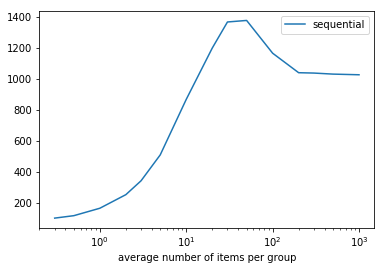

In [18]:
sum_rates.plot(logx=True)

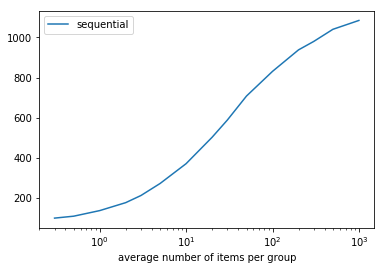

In [19]:
max_rates.plot(logx=True)

## Sequential algorithm 2: scatter from parents

The first sequential algorithm determined which items belong in which group from the `offsets` array, but it could have made that determination from the `parents` array. The `parents` array is aligned with `content` and will be crucial to the vectorized algorithms.

In [20]:
%%cython --cplus -c-O3 -c-ftree-vectorize

from libc.stdint cimport int32_t

cdef extern from "math.h": pass
cdef extern from "string.h": pass
cdef extern from "":
    """
void sequential2_sum_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output) {
    memset(output, 0, sizeof(float) * (len_offsets - 1));
    int32_t lastparent = -1;
    float cumulative = 0.0;
    int i;
    for (i = 0;  i < len_parents;  i++) {
        if (lastparent != -1  &&  lastparent != parents[i]) {
            output[lastparent] = cumulative;
            cumulative = 0.0;
        }
        cumulative += content[i];
        lastparent = parents[i];
    }
    if (lastparent != -1) {
        output[lastparent] = cumulative;
    }
}

void sequential2_max_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output) {
    for (int i = 0;  i < len_offsets - 1;  i++) {
        output[i] = -INFINITY;
    }
    int32_t lastparent = -1;
    float cumulative = -INFINITY;
    int i;
    for (i = 0;  i < len_parents;  i++) {
        if (lastparent != -1  &&  lastparent != parents[i]) {
            output[lastparent] = cumulative;
            cumulative = -INFINITY;
        }
        if (content[i] > cumulative) {
            cumulative = content[i];
        }
        lastparent = parents[i];
    }
    if (lastparent != -1) {
        output[lastparent] = cumulative;
    }
}
"""
    void sequential2_sum_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output)
    void sequential2_max_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output)

def sequential2_sum(offsets, parents, content, output):
    sequential2_sum_impl(len(offsets),
                         len(parents),
                         <int32_t*>(<size_t>parents.ctypes.data),
                         <float*>(<size_t>content.ctypes.data),
                         <float*>(<size_t>output.ctypes.data))

def sequential2_max(offsets, parents, content, output):
    sequential2_max_impl(len(offsets),
                         len(parents),
                         <int32_t*>(<size_t>parents.ctypes.data),
                         <float*>(<size_t>content.ctypes.data),
                         <float*>(<size_t>output.ctypes.data))

This is a new algorithm, so we must verify its correctness. In general (not this case), different algorithms add numbers in a different order, so we have to allow for small errors due to the non-associativity of floating-point addition.

In [21]:
import gc
def verify_correct(averagesize, run, which, location="/tmp/DATA"):
    offsets, parents, content = get_dataset(averagesize, location=location)
    output = numpy.empty(len(offsets) - 1, dtype=numpy.float32)
    run(offsets, parents, content, output)
    original = numpy.fromfile(open(os.path.join(location, "{}-{}".format(which, averagesize)), "rb"),
                              dtype=numpy.float32)
    mask1 = numpy.isfinite(output)
    mask2 = numpy.isfinite(original)
    if not numpy.array_equal(mask1, mask2) or numpy.absolute(output[mask1] - original[mask2]).max() > 0.003:
        print("averagesize {} {} is not correct".format(averagesize, which))
        return offsets, parents, content, output, original
    del offsets, parents, content, output, original
    gc.collect()
    return None, None, None, None, None

Now we can measure its performance.

In [22]:
for averagesize in averagesizes:
    print("sum", averagesize)
    sum_rates.loc[averagesize, "seq-parents"] = measure(averagesize, sequential2_sum)

sum 0.3
sum 0.5
sum 1.0
sum 2.0
sum 3.0
sum 5.0
sum 10.0
sum 20.0
sum 30.0
sum 50.0
sum 100.0
sum 200.0
sum 300.0
sum 500.0
sum 1000.0


In [23]:
for averagesize in averagesizes:
    print("max", averagesize)
    max_rates.loc[averagesize, "seq-parents"] = measure(averagesize, sequential2_max)

max 0.3
max 0.5
max 1.0
max 2.0
max 3.0
max 5.0
max 10.0
max 20.0
max 30.0
max 50.0
max 100.0
max 200.0
max 300.0
max 500.0
max 1000.0


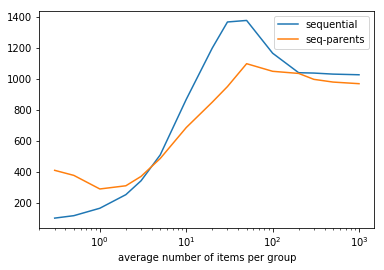

In [24]:
sum_rates.plot(logx=True)

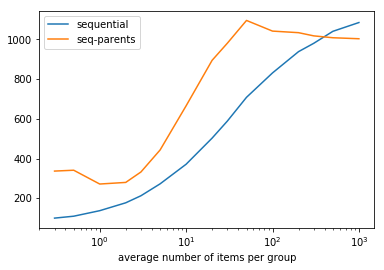

In [25]:
max_rates.plot(logx=True)

## Vectorized by 16

Below, Jaydeep's vectorized jagged reduction is implemented for a vector size of 16 items. Since these are 32-bit integers and floats, that means a 512-bit vector register (AVX-512). The code below will be _emulated_ on CPUs without AVX-512 instructions. Smaller vector units give less of a speedup because this algorithm approaches the sequential case as the vector size → one item.

In [26]:
%%cython --cplus -c-O3 -c-ftree-vectorize -c-march=native -c-mfma -c-Ivectorclass

cdef extern from "":
    "#define MAX_VECTOR_SIZE 512"   # must be defined before including vectorclass

from libc.stdint cimport int32_t

cdef extern from "math.h": pass
cdef extern from "string.h": pass
cdef extern from "vectorclass.h":
    """
void vectorized16_sum_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output) {
    memset(output, 0, sizeof(float) * (len_offsets - 1));

    Vec16f s;
    Vec16f scarry = {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0};
    Vec16i p;
    Vec16i pcarry = {-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1};

    Vec16i p2;
    Vec16i p2none = {-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1};

    for (int i = 0;  i < len_parents;  i += 16) {
        s.load(&content[i]);
        p.load(&parents[i]);
        p2.load(&parents[i + 1]);

        s = if_add(p == pcarry, s, scarry);

        s = if_add(p == permute16i<-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14>(p),
                   s,   permute16f<-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14>(s));

        s = if_add(p == permute16i<-1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13>(p),
                   s,   permute16f<-1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13>(s));

        s = if_add(p == permute16i<-1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11>(p),
                   s,   permute16f<-1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11>(s));

        s = if_add(p == permute16i<-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7>(p),
                   s,   permute16f<-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7>(s));

        scarry = blend16f<15, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31>(s, scarry);
        pcarry = blend16i<15, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31>(p, pcarry);

        scatter(select(p == p2, p2none, p), len_offsets, s, output);
    }
}

void vectorized16_max_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output) {
    for (int i = 0;  i < len_offsets - 1;  i++) {
        output[i] = -INFINITY;
    }

    Vec16f s;
    Vec16f scarry = {-INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY,
                     -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY};
    Vec16f szero  = {-INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY,
                     -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY, -INFINITY};
    Vec16f sblend;
    Vec16i p;
    Vec16i pcarry = {-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1};

    Vec16i p2;
    Vec16i p2none = {-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1};

    for (int i = 0;  i < len_parents;  i += 16) {
        s.load(&content[i]);
        p.load(&parents[i]);
        p2.load(&parents[i + 1]);

        s = select((p == pcarry) & (scarry > s), scarry, s);

        sblend           = blend16f<16,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14>(s, szero);
        s = select((p == permute16i<-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14>(p)) & (sblend > s), sblend, s);

        sblend           = blend16f<16, 16,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13>(s, szero);
        s = select((p == permute16i<-1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13>(p)) & (sblend > s), sblend, s);

        sblend           = blend16f<16, 16, 16, 16,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11>(s, szero);
        s = select((p == permute16i<-1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11>(p)) & (sblend > s), sblend, s);

        sblend           = blend16f<16, 16, 16, 16, 16, 16, 16, 16,  0,  1,  2,  3,  4,  5,  6,  7>(s, szero);
        s = select((p == permute16i<-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7>(p)) & (sblend > s), sblend, s);

        scarry = blend16f<15, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31>(s, scarry);
        pcarry = blend16i<15, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31>(p, pcarry);

        scatter(select(p == p2, p2none, p), len_offsets, s, output);
    }
}
"""
    void vectorized16_sum_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output)
    void vectorized16_max_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output)

def vectorized16_sum(offsets, parents, content, output):
    vectorized16_sum_impl(len(offsets),
                          len(parents),
                          <int32_t*>(<size_t>parents.ctypes.data),
                          <float*>(<size_t>content.ctypes.data),
                          <float*>(<size_t>output.ctypes.data))

def vectorized16_max(offsets, parents, content, output):
    vectorized16_max_impl(len(offsets),
                          len(parents),
                          <int32_t*>(<size_t>parents.ctypes.data),
                          <float*>(<size_t>content.ctypes.data),
                          <float*>(<size_t>output.ctypes.data))

In [27]:
for averagesize in averagesizes:
    print("sum", averagesize)
    sum_rates.loc[averagesize, "vectorized (AVX-512)"] = measure(averagesize, vectorized16_sum)

sum 0.3
sum 0.5
sum 1.0
sum 2.0
sum 3.0
sum 5.0
sum 10.0
sum 20.0
sum 30.0
sum 50.0
sum 100.0
sum 200.0
sum 300.0
sum 500.0
sum 1000.0


In [28]:
for averagesize in averagesizes:
    print("max", averagesize)
    max_rates.loc[averagesize, "vectorized (AVX-512)"] = measure(averagesize, vectorized16_max)

max 0.3
max 0.5
max 1.0
max 2.0
max 3.0
max 5.0
max 10.0
max 20.0
max 30.0
max 50.0
max 100.0
max 200.0
max 300.0
max 500.0
max 1000.0


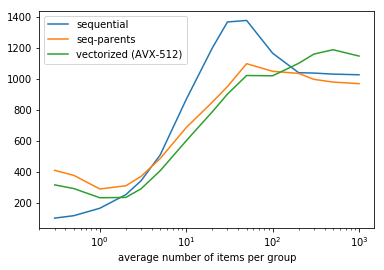

In [29]:
sum_rates.plot(logx=True)

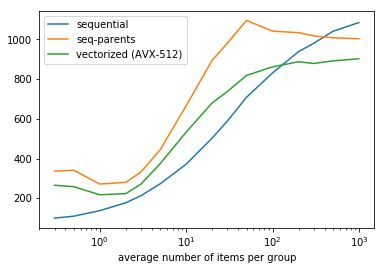

In [30]:
max_rates.plot(logx=True)

## Vectorized by 1024 (GPU/CUDA)

The same technique can be applied at a much larger scale on a GPU. The main difference in the CUDA code below is that we have no idea which order the blocks will be evaluated in, so passing partial events over vector borders (the "carry" in the algorithm above) must be performed as a separate step, to be sure that the first set of blocks have finished.

Since this step is likely to be part of a larger analysis performed on a GPU, with arrays already loaded on the GPU, we don't include the data copy from CPU to GPU in the performance. (Also, it depends heavily on the hardware, not a good test of the algorithm.)

In [9]:
import pycuda
import pycuda.autoinit
import pycuda.compiler
import pycuda.gpuarray

In [17]:
module = pycuda.compiler.SourceModule("""
__global__ void sum_step1(int len_offsets, int* offsets, float* output, int* blockoffsets) {
    int i = threadIdx.x + blockIdx.x*blockDim.x;
    // initialize output
    if (i < len_offsets - 1) {
        output[i] = 0.0;
    }
    
    // set up blockoffsets
    if (i != 0  &&  i < len_offsets - 1) {
        int prevblock = offsets[i - 1] / 1024;
        int thisblock = offsets[i] / 1024;
        if (prevblock != thisblock) {
            blockoffsets[thisblock] = offsets[i - 1];
        }
    }
}

__global__ void sum_step2(int* blockoffsets, int len_parents, int* parents, float* content, float* output) {
    int offset = blockoffsets[blockIdx.x];
    int nextoffset = blockoffsets[blockIdx.x + 1];
    
    // parallel cumulative sum
    int i = threadIdx.x;
    if (i < nextoffset - offset) {
        for (int d = 1;  d < 1024;  d *= 2) {
            if (i >= d  &&  parents[offset + i] == parents[offset + i - d]) {
                content[offset + i] += content[offset + i - d];
            }
            __syncthreads();
        }
    }

    // send the last element of each group to the output
    if ((offset + i < len_parents - 1  &&  parents[offset + i + 1] != parents[offset + i])  ||  offset + i == len_parents - 1) {
        output[parents[offset + i]] = content[offset + i];
    }

    // clean up extra items for groups that overhang the 1024 boundary (rare)
    if (nextoffset - offset > 1024  &&  i == 1023) {
        for (i = i + 1;  i < nextoffset - offset;  i++) {
            if (parents[offset + i] == parents[offset + i - 1]) {
                content[offset + i] += content[offset + i - 1];
            }
        }
        output[parents[offset + i - 1]] = content[offset + i - 1];
    }
}

__global__ void max_step1(int len_offsets, int* offsets, float* output, int* blockoffsets) {
    int i = threadIdx.x + blockIdx.x*blockDim.x;
    // initialize output
    if (i < len_offsets - 1) {
        output[i] = -INFINITY;
    }
    
    // set up blockoffsets
    if (i != 0  &&  i < len_offsets - 1) {
        int prevblock = offsets[i - 1] / 1024;
        int thisblock = offsets[i] / 1024;
        if (prevblock != thisblock) {
            blockoffsets[thisblock] = offsets[i - 1];
        }
    }
}

__global__ void max_step2(int* blockoffsets, int len_parents, int* parents, float* content, float* output) {
    int offset = blockoffsets[blockIdx.x];
    int nextoffset = blockoffsets[blockIdx.x + 1];
    
    // parallel cumulative sum
    int i = threadIdx.x;
    if (i < nextoffset - offset) {
        for (int d = 1;  d < 1024;  d *= 2) {
            if (i >= d  &&  parents[offset + i] == parents[offset + i - d]  &&  content[offset + i] < content[offset + i - d]) {
                content[offset + i] = content[offset + i - d];
            }
            __syncthreads();
        }
    }

    // send the last element of each group to the output
    if ((offset + i < len_parents - 1  &&  parents[offset + i + 1] != parents[offset + i])  ||  offset + i == len_parents - 1) {
        output[parents[offset + i]] = content[offset + i];
    }

    // clean up extra items for groups that overhang the 1024 boundary (rare)
    if (nextoffset - offset > 1024  &&  i == 1023) {
        for (i = i + 1;  i < nextoffset - offset;  i++) {
            if (parents[offset + i] == parents[offset + i - 1]  &&  content[offset + i] < content[offset + i - 1]) {
                content[offset + i] = content[offset + i - 1];
            }
        }
        output[parents[offset + i - 1]] = content[offset + i - 1];
    }
}
""")

sum_step1 = module.get_function("sum_step1")
sum_step2 = module.get_function("sum_step2")
max_step1 = module.get_function("max_step1")
max_step2 = module.get_function("max_step2")

In [18]:
def get_dataset_cuda(averagesize, location="/tmp/DATA"):
    offsets, parents, content = get_dataset(averagesize, location=location)
    offsets = pycuda.gpuarray.to_gpu(offsets)
    parents = pycuda.gpuarray.to_gpu(parents)
    content = pycuda.gpuarray.to_gpu(content)
    blockoffsets = pycuda.gpuarray.zeros(len(parents) // 1024 + 1, dtype=numpy.int32)
    output = pycuda.gpuarray.empty(len(offsets) - 1, dtype=numpy.float32)
    return offsets, parents, content, blockoffsets, output

def run_sum(offsets, parents, content, blockoffsets, output):
    sum_step1(numpy.int32(len(offsets)), offsets, output, blockoffsets,
              block=(1024, 1, 1), grid=(len(output) // 1024 + 1, 1))
    sum_step2(blockoffsets, numpy.int32(len(parents)), parents, content, output,
              block=(1024, 1, 1), grid=(len(blockoffsets) - 1, 1))

def run_max(offsets, parents, content, blockoffsets, output):
    max_step1(numpy.int32(len(offsets)), offsets, output, blockoffsets,
              block=(1024, 1, 1), grid=(len(output) // 1024 + 1, 1))
    max_step2(blockoffsets, numpy.int32(len(parents)), parents, content, output,
              block=(1024, 1, 1), grid=(len(blockoffsets) - 1, 1))

In [19]:
import time

def measure_cuda(averagesize, run, numtimes=10, location="/tmp/DATA"):
    offsets, parents, content, blockoffsets, output = get_dataset_cuda(averagesize, location=location)
    starttime = time.time()
    for i in range(numtimes):
        run(offsets, parents, content, blockoffsets, output)
    pycuda.driver.Context.synchronize()
    runtime = time.time() - starttime
    del offsets, parents, content, blockoffsets, output
    return tasksize * numtimes * 1e-6 / runtime   # MHz in number of particles (not events)

In [24]:
for averagesize in averagesizes[:-3]:
    print("sum", averagesize)
    sum_rates.loc[averagesize, "GPU"] = measure_cuda(averagesize, run_sum)

sum 0.3
sum 0.5
sum 1.0
sum 2.0
sum 3.0
sum 5.0
sum 10.0
sum 20.0
sum 30.0
sum 50.0
sum 100.0
sum 200.0


In [25]:
for averagesize in averagesizes[:-3]:
    print("max", averagesize)
    max_rates.loc[averagesize, "GPU"] = measure_cuda(averagesize, run_max)

max 0.3
max 0.5
max 1.0
max 2.0
max 3.0
max 5.0
max 10.0
max 20.0
max 30.0
max 50.0
max 100.0
max 200.0


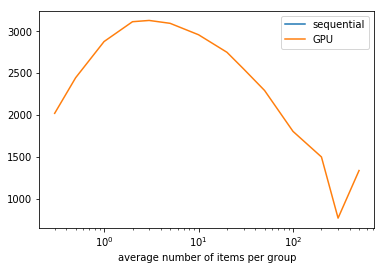

In [26]:
sum_rates.plot(logx=True).get_figure().savefig("sum_rates.pdf")

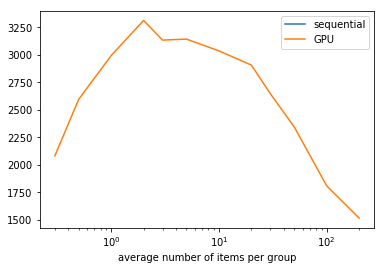

In [27]:
max_rates.plot(logx=True).get_figure().savefig("max_rates.pdf")